In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import os
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

from data_processing._common.query_runner import QueryRunner

# define database connection
db_name = "urbanmining"
username = "postgres"
password = "Tunacompany5694!"
host = "localhost"  # or your host if it's not local
port = "5432"  # default port for PostgreSQL

connection_string = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)

# Research questions
- Did the housing market achieve its goals in emissions reduction? 
- How did embodied and operational carbon contribute to emissions? 
- Which were the best performing municipalities / neighborhoods in the past decade? 
- What determines the success of the municipality / neighborhood? 

# Did the housing market achieve its goals in emissions reduction? 

In [11]:
query = ''' 
SELECT year, SUM(emissions_operational) AS operational, SUM(emissions_embodied) AS embodied
FROM emissions_all
WHERE year IS NOT NULL
GROUP BY year
'''
df = pd.read_sql_query(query, engine)
df_long = df.melt(id_vars='year', value_vars=['operational', 'embodied'], var_name='type', value_name='emissions')
df_long['emissions'] = df_long.emissions / 1000

fig = px.bar(df_long, x='year', y='emissions', color='type', title="NL housing emissions",
             labels={'emissions': 'Emissions (tCO2eq)', 'year': 'Year', 'type': 'Emission Type'})
fig.update_layout(width=800)
fig.show()

In [12]:
carbon_budget_embodied = 41000000000 # 41 billion kgCO2eq 
df['embodied_cumulative'] = df['embodied'].cumsum()
df['remaining_carbon_budget_embodied'] = carbon_budget_embodied - df['embodied_cumulative']
carbon_budget_operational = 71000000000 # 71 billion kgCO2eq 
df['operational_cumulative'] = df['operational'].cumsum()
df['remaining_carbon_budget_operational'] = carbon_budget_operational - df['operational_cumulative']
carbon_budget_total = carbon_budget_embodied + carbon_budget_operational
df['total'] = df['embodied'] + df['operational']
df['total_cumulative'] = df['total'].cumsum()
df['remaining_carbon_budget_total'] = carbon_budget_total - df['total_cumulative']

fig = px.line(df, x='year', y=['remaining_carbon_budget_embodied', 'remaining_carbon_budget_operational', 'remaining_carbon_budget_total'],
              title="Remaining carbon budget")
fig.show()

# How did embodied and operational carbon contribute to emissions? 

In [25]:
query = '''
SELECT year, municipality, 
	SUM(emissions_operational) AS operational, 
	SUM(emissions_embodied) AS embodied
FROM emissions_all
WHERE year IS NOT NULL
GROUP BY year, municipality
''' 
df = pd.read_sql_query(query, engine)
df_long = df.melt(id_vars=['year', 'municipality'], value_vars=['operational', 'embodied'],
                  var_name='type', value_name='emissions')
fig = px.box(df_long, x='year', y='emissions', color='type', # points=False, 
             title="Operational vs embodied emissions of municipalities",
             labels={'emissions': 'Emissions (kgCO2eq)', 'year': 'Year', 'type': 'Emission Type'})
fig.update_layout(width=1000)
fig.show()

In [43]:
query = ''' 
SELECT municipality, 
	SUM(emissions_operational) AS operational, 
	SUM(emissions_embodied) AS embodied
FROM emissions_all
WHERE emissions_operational IS NOT NULL
GROUP BY municipality
'''
df = pd.read_sql_query(query, engine)
av_operational = df['operational'].mean()
av_embodied = df['embodied'].mean()
def classify_municipality(row): 
    if row.operational > av_operational and row.embodied > av_embodied: 
        return 'high operational, high embodied'
    elif row.operational > av_operational and row.embodied < av_embodied:
        return 'high operational, low embodied'
    elif row.operational < av_operational and row.embodied > av_embodied:
        return 'low operational, high embodied'
    else:
        return 'low operational, low embodied'
df['municipality_type'] = df.apply(lambda row: classify_municipality(row), axis=1)

fig = px.scatter(df, x='operational', y='embodied', log_x=True, log_y=True, 
                 hover_name='municipality', color='municipality_type',
                 title="Operational vs embodied emissions of municipalities") 
fig.update_layout(width=800, height=500)
fig.show()

# TODO: map of nl with municipalities colored by type

# Which were the best performing municipalities / neighborhoods in the past decade? 
- Which neighborhoods / municipalities had the least emissions overall (per person and per sqm)
- Which neighborhoods / municipalities had the largest emissions reductions? (per person and per sqm)

In [12]:
query = ''' 
WITH emissions_by_municipality AS (
	SELECT municipality, 
		SUM(emissions_operational) AS operational, 
		SUM(emissions_embodied) AS embodied
	FROM emissions_all
	WHERE year IS NOT NULL
	GROUP BY municipality
), 
population AS (
	SELECT gm_naam AS municipality, SUM(aant_inw) AS population
	FROM cbs_map_all
	WHERE year = 2021
	GROUP BY gm_naam
)
SELECT
	e.*, e.operational + e.embodied AS total_emissions, 
	p.population
FROM emissions_by_municipality e 
LEFT JOIN population p  
ON e.municipality = p.municipality
'''
df = pd.read_sql_query(query, engine)
fig = px.scatter(df, x='population', y='total_emissions', 
                 log_x=True, log_y=True, hover_name='municipality', 
                 labels={'population': 'Population in 2021', 'total_emissions': 'Total Emissions'}, 
                 title="Population vs total emissions of municipalities")
fig.update_layout(width=800, height=500)
fig.show()
# TODO: Bonus - each municipality has two points, one for 2012 and one for 2021.

In [2]:
# scatter plot of municipalities, x-axis population change (2021 - 2012), y-axis total emissions
df = QueryRunner('sql/reporting/emissions_vs_populationChange.sql').get_dataframe_from_query()
fig = px.scatter(
    df, x='population_change', y='total_emissions', hover_name='municipality',
    # log_x=True, log_y=True,  
    labels={'population_change': 'Population change (2012-2021)', 'total_emissions': 'Total Emissions'}, 
    title="Population change vs total emissions of municipalities"
    )
fig.update_layout(width=800, height=500)
fig.show()

In [ ]:
# scatter plot of municipalities, x-axis sqm change (2012 - 2021), y-axis total emissions.

# scatter plot of municipalities, x-axis sqm change (2012 - 2021), y-axis population change (2012 - 2021)

# bonus: 3D scatter plot of municipalities, x-axis sqm change (2012 - 2021), y-axis population change (2012 - 2021), z-axis total emissions 

# What determines the success of a municipality / neighborhood? 
- which performs better - shrinking, growing, or consistent municipalities? (in terms of population)
- we are building more sqm of housing per person than before. (How) does this affect emissions? 
- we are trying to renovate more instead of building from scratch. (How) does this affect emissions? 

In [ ]:
# scatter plot for remaining carbon budget (per person vs per sqm), color by shrinking, growing, or stable population

# Visualize embodied emissions (2011 - now)
- total embodied emissions 
- embodied emissions for one municipality
- embodied emissions for all municipalities (highlight highest and lowest municipalities)

In [9]:
# get embodied emissions for housing in NL
query = ''' 
SELECT year, status, SUM(emissions_embodied_kg) AS emissions_embodied_kg
FROM emissions_embodied_housing_nl 
WHERE year >= 2012 AND year <= 2022
GROUP BY year, status
ORDER BY year, status
'''
df_byStatus = pd.read_sql_query(query, engine)
def translate_status(x): 
    if x == 'Bouw gestart': 
        return 'Construction'
    elif x == 'Pand gesloopt': 
        return 'Demolition'
    elif x == 'Verbouwing pand': 
        return 'Renovation'
    else: 
        return x 
df_byStatus.status = df_byStatus.status.map(lambda x: translate_status(x))

# bar chart for embodied emissions per year
fig = px.bar(df_byStatus, x='year', y='emissions_embodied_kg', color = 'status', title='Embodied emissions per year for housing in NL')
fig.show()

df = df_byStatus.groupby('year').sum().emissions_embodied_kg.reset_index()

# calculate cumulative emissions and carbon budget
carbon_budget = 41000000 # carbon budget for only embodied emissions. budget for all emissions is 112,000,000 tons 
df['cumulative_emissions'] = df['emissions_embodied_kg'].cumsum()
df['carbon_budget'] = carbon_budget - df['cumulative_emissions']

# line chart for cumulative embodied emissions and carbon budget 
fig = px.line(df, x='year', y=['cumulative_emissions', 'carbon_budget'], title='Cumulative embodied emissions for housing in NL')
fig.update_yaxes(range=[0, None])
fig.show()

# TODO: combine pre and post renovation into one category - renovation

In [18]:
df_byStatus

,year,status,emissions_embodied_tons
0,2012,Construction,1534601.860
1,2012,Demolition,463578.346
2,2012,renovation - pre2020,NaN
3,2012,transformation - adding units,NaN
4,2012,transformation - function change,NaN
5,2013,Construction,1119361.112
6,2013,Demolition,393605.597
7,2013,renovation - pre2020,NaN
8,2013,transformation - adding units,NaN
9,2013,transformation - function change,NaN


Top ten municipalities: ['Amsterdam', 'Utrecht', 'Eindhoven', "'s-Gravenhage", 'Rotterdam', 'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda']
Bottom ten municipalities: ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']


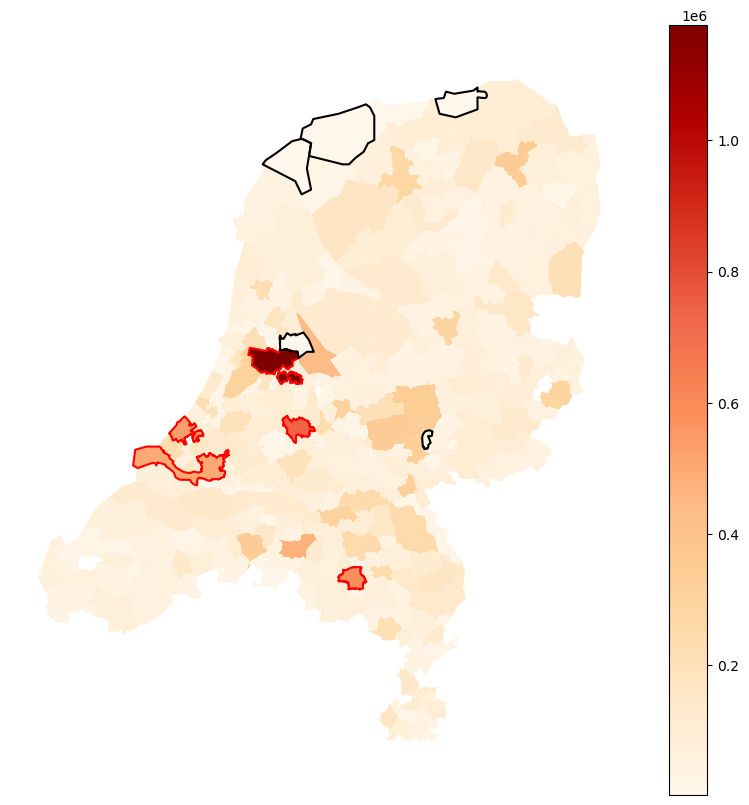

In [23]:
# embodied emissions total
query = ''' 
WITH emissions AS (
	SELECT municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
	FROM emissions_embodied_housing_nl 
	WHERE year >= 2011 AND year <= 2022 -- AND municipality = 'Delft'
	GROUP BY municipality
)
SELECT e.*, g.geom
FROM emissions e 
JOIN nl_gemeentegebied g 
ON e.municipality = g.naam
ORDER BY e.emissions_embodied_tons DESC
'''
gdf = gpd.read_postgis(query, engine)

# top and bottom five municipalities 
top_five = gdf.head(10).municipality.tolist()
bottom_five = gdf.tail(10).municipality.tolist()
print(f'Top ten municipalities: {top_five}')
print(f'Bottom ten municipalities: {bottom_five}')

# plot on map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='emissions_embodied_tons', legend=True, cmap='OrRd', ax=ax)
gdf.head().boundary.plot(ax=ax, color='red')
gdf.tail().boundary.plot(ax=ax, color='black')
ax.axis('off')
plt.show()

In [36]:
# horizontal bar chart for embodied emissions per municipality
fig = px.bar(gdf, x='emissions_embodied_tons', y='municipality', title='Embodied emissions per municipality for housing in NL')
fig.update_layout(width=800, height=600)
fig.show()

In [33]:
# by status
query = f'''
SELECT municipality, status, SUM(sqm) AS sqm, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl
WHERE 
    municipality IN (
        'Amsterdam', 'Utrecht', 'Eindhoven', \'\'\'s-Gravenhage', 'Rotterdam',
        'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda'
        )
    AND year >= 2012 AND year < 2024
GROUP BY municipality, status
'''
df = pd.read_sql_query(query, engine)
df.status = df.status.map(lambda x: translate_status(x))
municipality_order = ['Amsterdam', 'Utrecht', 'Eindhoven', "'s-Gravenhage", 'Rotterdam', 'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda']
status_order = ['Construction', 'Demolition', 'Renovation']

color_discrete_map = {
    'Construction': px.colors.qualitative.Plotly[0],  # Construction
    'Demolition': px.colors.qualitative.Plotly[1],   # Demolition
    'Renovation': px.colors.qualitative.Plotly[2] # Renovation
}

fig = px.bar(df, x='emissions_embodied_tons', y='municipality', color='status',  
             title='Embodied emissions by status for top ten municipalities (2011 - 2024)', 
             category_orders={'municipality': municipality_order, 'status': status_order},
             color_discrete_map=color_discrete_map)
fig.update_layout(width=1000)
fig.show()

In [37]:
# by status

bottom_ten = ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
              'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']

query = f'''
SELECT municipality, status, SUM(sqm) AS sqm, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl
WHERE 
    municipality IN (
        'Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
        'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog'
        )
    AND year >= 2012 AND year < 2024
GROUP BY municipality, status
'''
df = pd.read_sql_query(query, engine)
df.status = df.status.map(lambda x: translate_status(x))
municipality_order = ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
                      'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']
status_order = ['Construction', 'Demolition', 'Renovation']

color_discrete_map = {
    'Construction': px.colors.qualitative.Plotly[0],  # Construction
    'Demolition': px.colors.qualitative.Plotly[1],   # Demolition
    'Renovation': px.colors.qualitative.Plotly[2] # Renovation
}

fig = px.bar(df, x='emissions_embodied_tons', y='municipality', color='status',  
             title='Embodied emissions by status for bottom ten municipalities (2011 - 2024)', 
             category_orders={'municipality': municipality_order, 'status': status_order},
             color_discrete_map=color_discrete_map)
fig.update_layout(width=1000)
fig.show()

In [ ]:
query = ''' 
SELECT year, municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl 
WHERE year >= 2011 AND year <= 2022 
GROUP BY year, municipality
ORDER BY year, municipality
'''
df = pd.read_sql_query(query, engine)
df['cumulative_emissions'] = df.sort_values('year').groupby('municipality')['emissions_embodied_tons'].cumsum()
df = df[df['municipality'].isin(top_five + bottom_five)]

fig = px.line(df, x='year', y='cumulative_emissions', color='municipality', title='Cumulative embodied emissions per year for housing in NL')
fig.show()

In [ ]:
# emissions for one municipality
def get_data_for_municipality(municipality_name, engine): 
    query = f''' 
    SELECT year, SUM(emissions_embodied_tons) AS emissions_embodied_tons
    FROM emissions_embodied_housing_nl 
    WHERE year >= 2011 AND year <= 2022 AND municipality = '{municipality_name}'
    GROUP BY year
    '''
    df = pd.read_sql_query(query, engine)    
    df['cumulative_emissions'] = df['emissions_embodied_tons'].cumsum()
    
    return df 

def plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, type='cumulative'):
    if type == 'cumulative':
        title = f'Cumulative embodied emissions per year for housing in {municipality_name}'
        y = 'cumulative_emissions'
    else: 
        title = 'Embodied emissions per year for housing in ' + municipality_name
        y = 'emissions_embodied_tons'
    
    fig = px.line(df, x='year', y=y, title=title)
    fig.show()

municipality_name = 'Amsterdam'
df = get_data_for_municipality(municipality_name, engine)
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'n cumulative')
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'cumulative')